# PonCenter dealer assistant PoC (Semantic search)


## Dataset diagram
<img height="400px" src="https://dev-icp.s3.eu-central-1.amazonaws.com/dataengineering/database_diagram_v2.png">

In [198]:
# !zip -r zipped.zip sbert-triplet-finetuned/
# !pip install sacremoses

In [197]:
# Packages installeren
!pip install pandas
!pip install transformers
!pip install spacy
!pip install torch
!spacy download nl_core_news_sm
!pip install sentence-transformers faiss-cpu
!pip install sacremoses

# Imports
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import pandas as pd
import spacy
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [199]:
# Inladen van datasets vanuit AWS S3 bucket
_S3Path = 'https://dev-icp.s3.eu-central-1.amazonaws.com/dataengineering/'

# werkorders_df = pd.read_csv(_S3Path + 'workorders.csv')
# koppeltabel_df = pd.read_csv(_S3Path + 'join.csv')
# voertuigen_df = pd.read_csv(_S3Path + 'vehicles.csv')
berichten_df = pd.read_csv(_S3Path + 'remarks.csv')
taken_df = pd.read_csv(_S3Path + 'works.csv')# Overkoepelende tabel; kan je beter zien als pakketten (includeerd arbeid en onderdelen later in het process)
triplets_df = pd.read_csv(_S3Path + 'triplets.csv') # 304 pairs
triplets_v2_df = pd.read_csv(_S3Path + 'triplets_v2.csv') # 1024 pairs

/tmp/ipython-input-2378465771.py:7: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  berichten_df = pd.read_csv(_S3Path + 'remarks.csv')


## Kort overzicht analyze op de datasets

In [200]:
berichten_df.head(3)

,id,workorder_id,remark_type,crm_partner_id,department,to_crm_partner_id,remarks,read,priority,remark_status,...,in_progress_datetime,postpone_datetime,postpone_reason,remark_parent_id,crm_partner_completed_id,completed_datetime,source,source_id,created,modified
0,104233,413943,diagnosis,420380,front_desk,50.0,NaN,NaN,action-required,handled,...,NaN,NaN,NaN,NaN,319048.0,2022-02-02 21:52:00,NaN,NaN,2022-02-02 20:03:27,2022-02-02 21:52:00
1,104234,413944,labor_signed,7,chief_workshop,50.0,De status is gewijzigd van 1 arbeidsregel(s) v...,NaN,action-required,handled,...,NaN,NaN,NaN,NaN,319048.0,2022-02-02 20:44:12,NaN,NaN,2022-02-02 20:40:37,2022-02-02 20:44:12
2,104235,413944,diagnosis,319048,warehouse,50.0,test,NaN,action-required,handled,...,2022-02-02 20:43:49,NaN,NaN,NaN,319048.0,2022-02-02 20:43:52,NaN,NaN,2022-02-02 20:43:36,2022-02-02 20:43:52


In [201]:
print('Unique departments: ', berichten_df['department'].unique())
print('Unique types: ', berichten_df['remark_type'].unique())

Unique departments:  ['front_desk' 'chief_workshop' 'warehouse' 'warranty' 'workshop'
 'orderpicker' 'kcc' 'backoffice' 'telephone_operators']
Unique types:  ['diagnosis' 'labor_signed' 'warranty' 'check_delivery'
 'customer_feedback' 'other' 'make_appointment' 'autoline_exception'
 'partner_name_changed' 'part_availability' 'partner_changed'
 'customer_labor_statement' 'damage' 'workorder_finished'
 'maintenance_rejected' 'diagnosis_rejected' 'key_dropped'
 'customer_contact']


In [202]:
taken_df.head(10)

,id,cid,description,created,modified
0,1,BARDIAG,Diagnose Occassion,2021-05-18 11:52:00,2025-11-09 01:30:02
1,8,PAF001,Nieuw Verhuur VW Kost.Rijkl.Maken,2021-05-18 11:52:00,2025-11-09 01:30:02
2,9,PAF002,Nieuw Verhuur Audi Kost.Rijkl.Maken,2021-05-18 11:52:00,2025-11-09 01:30:02
3,10,PAF003,Nieuw Verhuur LKW Kost.Rijkl.Maken,2021-05-18 11:52:00,2025-11-09 01:30:02
4,11,PAF004,Nieuw Verhuur VW Kost.Rijkl.Maken,2021-05-18 11:52:00,2025-11-09 01:30:02
5,12,PAF005,Nieuw Verhuur Seat Kost.Rijkl.Maken,2021-05-18 11:52:00,2025-11-09 01:30:02
6,89,PDE001,Eigen Risico Pon Plus Garantie,2021-05-18 11:52:02,2025-11-09 01:30:02
7,90,PDE002,Ruitconcept voorruit 1e ster-reparatie. Let op...,2021-05-18 11:52:02,2025-11-09 01:30:02
8,91,PDE003,Ruitconcept voorruit tweede ster-reparatie. Le...,2021-05-18 11:52:02,2025-11-09 01:30:02
9,92,PLAATWM,Plaat en Spuitwerk,2021-05-18 11:52:02,2025-11-09 01:30:02


In [203]:
triplets_df.head()

,anchor,positive,negative
0,"VPS sidebars, Transporter lange wielbasis",Alcochem Side-Bars T5 / T6 / T6.1 L2 RVS Mat,"Tussenschot bekleed zonder ruit, 2 schuifdeur"
1,Wiellager vervangen (Achter),Ruitenwissers vervangen (Achter),Equinox Imperiaal Caddy RVS (met deuren)
2,Frontspoiler Transporter 6.1 hoogglans zwart,Frontspoiler Transporter 6.1,Navigatie update (actie)
3,Zomer/winterwissel (set zonder opslag),Zomer/winterwissel (set met opslag),Parrot Mki-9200 bluetooth handsfree carkit
4,"ID Buzz Cargo Glass Look Paneel, bijrijderszijde","ID Buzz Cargo Glass Look Paneel, bestuurderszijde",Connected Car Module


In [204]:
triplets_df.negative.value_counts().head(9)

,count
negative,
"Velours mattenset Polo, voor en achter",69
Imperiaal aluminium,51
Bluetooth carkit,41
Bluetooth autoradio,39
Imperiaal RVS,33
Navigatie update Europa,16
Navigatie update (actie),7
Rubber vloermat laadruimte L1,5
Airco vullen,4


In [205]:
triplets_v2_df.negative.value_counts().head(4)

,count
negative,
Inspectie met olie verversen (variabel),4
Remblokken achter vervangen,3
Schokdempers vervangen (Achter),3
Rubber vloermat laadruimte L1,3


# Datasets opschonen (cleanup)

## Berichten opschonen

In [206]:
berichten_df = berichten_df[berichten_df['remark_type'] == 'customer_contact'];

drop_columns = [
    'crm_partner_id',
    'to_crm_partner_id',
    'read',
    'remark_status',
    'postpone_datetime',
    'crm_partner_completed_id',
    'completed_datetime',
    'crm_partner_in_progress_id',
    'in_progress_datetime',
    'source_id',
    'created',
    'modified',
    'department'
]


berichten_df = berichten_df.drop(
    # Alleen kollommen die nu bestaan in de dataframe verwijderen
    columns=[col for col in drop_columns if col in berichten_df.columns.tolist()]
)

# klant berichten (1821 entries) ⊆ totale berichten (848127 entries); -99.79%
berichten_df.head()


,id,workorder_id,remark_type,remarks,priority,postpone_reason,remark_parent_id,source
804543,1247972,796945,customer_contact,Klant bericht test,medium,NaN,NaN,NaN
804544,1247973,796945,customer_contact,Afbeelding klantportaal test,medium,NaN,NaN,NaN
804585,1248388,794612,customer_contact,"Goedemorgen,\n\nIk heb bij het inchecken aange...",medium,NaN,NaN,NaN
804633,1248785,798678,customer_contact,Wat is de situzatie op dit moment? Auto is sin...,medium,NaN,NaN,NaN
804674,1249080,797158,customer_contact,"Hoi, ik zie dat het voertuig nog steeds staat ...",medium,NaN,NaN,NaN


## Taken opschonen

In [207]:
print(taken_df.shape)
taken_df = taken_df.drop_duplicates(subset="description", keep="last")
taken_df.shape


(21217, 5)


(3138, 5)

In [208]:
triplets_df.shape

(299, 3)

## Syntetisch verijkte training data
Dit doe ik d.m.v. hergebruiken van anchors en als positieve value een geparafiseerde anchor en als een negatief gebruik ik een


In [209]:
nl_en_model_name = "Helsinki-NLP/opus-mt-nl-en"
en_nl_model_name = "Helsinki-NLP/opus-mt-en-nl"

nl_en_tokenizer = AutoTokenizer.from_pretrained(nl_en_model_name)
nl_en_model = AutoModelForSeq2SeqLM.from_pretrained(nl_en_model_name)

en_nl_tokenizer = AutoTokenizer.from_pretrained(en_nl_model_name)
en_nl_model = AutoModelForSeq2SeqLM.from_pretrained(en_nl_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nl_en_model = nl_en_model.to(device)
en_nl_model = en_nl_model.to(device)

anchors_list = triplets_v2_df["anchor"].tolist()


def translate(text, tokenizer, model):
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    out = model.generate(
        **enc,
        max_length=128,
        num_beams=5
    )

    return tokenizer.decode(out[0], skip_special_tokens=True)


def paraphrase(text):
    en = translate(text, nl_en_tokenizer, nl_en_model) # NL -> EN
    nl = translate(en, en_nl_tokenizer, en_nl_model) # EN -> NL
    return nl

In [210]:
rows = []

for _, row in tqdm(triplets_v2_df.iterrows(), total=len(triplets_v2_df), desc="Paraphrasing (NL→EN→NL)"):
    anchor = row["anchor"]

    # Korte anchors overslaan (weinig om te parafraseren)
    if len(anchor.split()) <= 3:
        continue

    negative = random.choice(anchors_list)
    while negative == anchor:
        negative = random.choice(anchors_list)

    try:
        positive = paraphrase(anchor)

        if positive.lower().strip() != anchor.lower().strip():
            rows.append({
                "anchor": anchor,
                "positive": positive,
                "negative": negative
            })

    except Exception as e:
        print("Error:", anchor, e)

synthetic_df = pd.DataFrame(rows)

extended_df = pd.concat([triplets_v2_df, synthetic_df], ignore_index=True)

print("Original:", len(triplets_v2_df))
print("Synthetic:", len(synthetic_df))
print("Extended:", len(extended_df))


Paraphrasing (NL→EN→NL): 100%|██████████| 1058/1058 [01:42<00:00, 10.28it/s]

Original: 1058
Synthetic: 176
Extended: 1234


In [211]:
print(synthetic_df.shape)
synthetic_df.head(10)

(176, 3)


,anchor,positive,negative
0,"VPS sidebars, Transporter lange wielbasis","VPS zijbalken, Transporter lange wielbasis",Hybride storing
1,Frontspoiler Transporter 6.1 hoogglans zwart,Voorspoiler Transporter 6.1 hoogglans zwart,Parkeerhulp remt auto
2,Zomer/winterwissel (set zonder opslag),Zomer/winterverandering (ingesteld zonder opslag),Ventilator blijft draaien
3,"ID Buzz Cargo Glass Look Paneel, bijrijderszijde","ID Buzz Cargo Glass Look Panel, passagierszijde",Camber afstelling nodig
4,APK-keuring incl. afm. kosten,APK-verificatie inclusief kosten,Startonderbreker storing
5,"APK i.c.m. OH SE,SK","APK in samenwerking met OH SE,SK",Wiellager diagnose
6,Ruitconcept voorruit 1e ster-reparatie. Let op...,Windscherm concept 1e ster reparatie. Let op! ...,Stuur uitlijnen
7,Voorruit vervangen bij PC Nieuwegein,Voorruit vervangen door PC Nieuwegein,Koplamp flikkert
8,Technocon uitbreiding MI50 t.b.v. klasse VVS,Technocon uitbreiding MI50 voor klasse VVS,Differentieel warm
9,"VPS sidebars, Transporter lange wielbasis","VPS zijbalken, Transporter lange wielbasis",Infotainment traag


# Sementic search met SBERT en RAG


## Dataset splitting

In [212]:
training_df = extended_df.sample(frac=0.8, random_state=25)
testing_df = extended_df.drop(training_df.index)

testing_df.shape, training_df.shape, extended_df.shape

((247, 3), (987, 3), (1234, 3))

## Model training

In [213]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import pandas as pd

train_examples = [
    InputExample(texts=[row.anchor, row.positive, row.negative])
    for _, row in training_df.iterrows()
]

# Inladen van een pretrained multilanguage SBERT model
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=64
)

train_loss = losses.TripletLoss(
    model=model,
    distance_metric=losses.TripletDistanceMetric.COSINE,
)

# Train/Fitting
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=50,
    show_progress_bar=True
)

# Saving fine tuned model
model.save("sbert-triplet-finetuned")


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


## Genereren van embeddings (vectors)
Embeddings zijn opgeslagen in de runtime als een dataframe

In [214]:
from sentence_transformers import SentenceTransformer

# reusing fine tuned model
model = SentenceTransformer("sbert-triplet-finetuned")

taken_descriptions = taken_df['description'].tolist()

# Generate embeddings for the descriptions
embeddings = model.encode(
    taken_descriptions,
    show_progress_bar=True,
    convert_to_numpy=True
).astype("float32")

embeddings.shape

The tokenizer you are loading from 'sbert-triplet-finetuned' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

(3138, 512)

## Aaanmaken van een search index (d.m.v. FAISS)

In [215]:
import faiss
import numpy as np

# Normaliseer embeddings voor de cosine similarity
faiss.normalize_L2(embeddings)

dimension = embeddings.shape[1]

# Cosine similarity via inwendig product
search_index = faiss.IndexFlatIP(dimension)
search_index.add(embeddings)

print(f"({search_index.ntotal} vectors, dimension {dimension}).")


(3138 vectors, dimension 512).


## Zoeken in de embeddings

In [216]:
def search(query_text, k=5):
  query_embedding = model.encode([query_text]).astype("float32")
  faiss.normalize_L2(query_embedding)

  scores, indices = search_index.search(query_embedding, k)

  results = []
  for i, idx in enumerate(indices[0]):
      results.append({
          "description": taken_descriptions[idx],
          "score": float(scores[0][i])
      })
  return results

In [217]:
search('Kan het Koel- en remvloeistof vervangen worden?')

[{'description': 'Koudemiddel R744 vervangen (warmtepomp)',
  'score': 0.7875245809555054},
 {'description': 'Koelvloeistof afgetapt en gevuld',
  'score': 0.7752549648284912},
 {'description': 'Koelvloeistof verversen', 'score': 0.7747195959091187},
 {'description': 'Thermostaathuis vervangen', 'score': 0.7577322721481323},
 {'description': 'Modificatie: Koelvloeistof verlies (reg./pomp                 (0.00)',
  'score': 0.7415731549263}]

# Model testing (Resultaten en evaluatie)

In [218]:
TP = FP = FN = TN = 0

def in_result(query, results) -> bool:
    for result in results:
        if not isinstance(result['description'], str):
          continue
        if query.strip().lower() in result['description'].strip().lower():
          return True
        for part in query.split():
          if part.strip().lower() in result['description'].strip().lower():
            return True

    return False


for index, row in testing_df.iterrows():
    anchor = row['anchor']
    positive = row['positive']

    results = search(anchor, k=10)

    if in_result(positive, results):
        TP += 1
    else:
        FP += 1

    if in_result(negative, results):
        FN += 1
    else:
        TN += 1

print(f"True Positives (TP):  {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN):  {TN}")

True Positives (TP):  146
False Negatives (FN): 6
False Positives (FP): 101
True Negatives (TN):  241


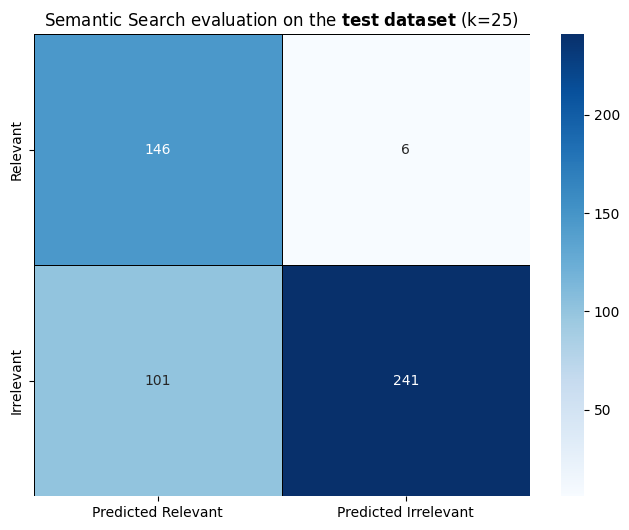

In [219]:
confusion_matrix_data = np.array([
    [TP, FN],
    [FP, TN]
])

annotations = np.array([
    [f'{TP}', f'{FN}'],
    [f'{FP}', f'{TN}']
])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, annot=annotations , fmt="", cmap="Blues",
            xticklabels=['Predicted Relevant', 'Predicted Irrelevant'],
            yticklabels=['Relevant', 'Irrelevant'],
            linewidths=.5, linecolor='black')
plt.title(r'Semantic Search evaluation on the $\bf{test\ dataset}$ (k=10)')
plt.show()

## Metrics

- **Accuracy** = $\displaystyle \frac{TP + TN}{TP + TN + FP + FN}$  
  [Accuracy in Wikipedia][accuracy]

- **Precision** = $\displaystyle \frac{TP}{TP + FP}$  
  [Precision in Wikipedia][precision_recall]

- **Recall (Sensitivity)** = $\displaystyle \frac{TP}{TP + FN}$  
  [Recall in Wikipedia][precision_recall]

- **Specificity** = $\displaystyle \frac{TN}{TN + FP}$  
  [Specificity in Wikipedia][specificity]

- **F1-Score** = $\displaystyle \frac{2TP}{2TP + FP + FN}$  
  [F1-Score in Wikipedia][f1]

---

[accuracy]: https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification
[precision_recall]: https://en.wikipedia.org/wiki/Precision_and_recall
[specificity]: https://en.wikipedia.org/wiki/Sensitivity_and_specificity
[f1]: https://en.wikipedia.org/wiki/F-score


In [220]:
# Aandeel correct voorspelde gevallen (zowel positief als negatief) van alle gevallen
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Van alle als positief voorspelde gevallen: welk deel is echt positief (maat voor fout-positieven)
precision = TP / (TP + FP)

# Van alle echte positieve gevallen: welk deel wordt correct gevonden (maat voor gemiste positieven)
recall = TP / (TP + FN)

# Van alle echte negatieve gevallen: welk deel wordt correct als negatief voorspeld
specificity = TN / (TN + FP)

# Harmonisch gemiddelde van precision en recall; balans tussen beide
f1_score = (2 * (precision * recall)) / (precision + recall)

print(f"Accuracy:    {accuracy:.4f} ({(accuracy * 100):.1f}%)")
print(f"Precision:   {precision:.4f} ({(precision * 100):.1f}%)")
print(f"Recall:      {recall:.4f} ({(recall * 100):.1f}%)")
print(f"Specificity: {specificity:.4f} ({(specificity * 100):.1f}%)")
print(f"F1-Score:    {f1_score:.4f} ({(f1_score * 100):.1f}%)")

Accuracy:    0.7834 (78.3%)
Precision:   0.5911 (59.1%)
Recall:      0.9605 (96.1%)
Specificity: 0.7047 (70.5%)
F1-Score:    0.7318 (73.2%)
